In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = '2016-12-20'
end_date = '2017-01-02'
calculated_temps = calc_temps(start_date, end_date)
temps_df = pd.DataFrame(calculated_temps, columns =('tmin','tavg','tmax'))
temps_df.head()

,tmin,tavg,tmax
0,62.0,71.818182,78.0


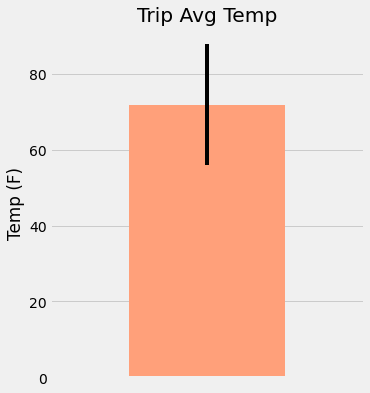

<Figure size 432x288 with 0 Axes>

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(5,6))
ax = temps_df['tavg'].plot.bar(yerr = (temps_df['tmax']-temps_df['tmin']), color='lightsalmon', title = "Trip Avg Temp", ylabel = "Temp (F)")
ax.axes.get_xaxis().set_visible(False)
plt.show()
plt.tight_layout()
ax.figure.savefig('Trip Avg Temp', bbox_inches='tight')

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, 
       func.sum(Measurement.prcp),
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation
      ]
station_totals = session.query(*sel).\
        filter(Measurement.station == Station.station, func.strftime(Measurement.date) >= start_date, func.strftime(Measurement.date) <= end_date).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

station_totals

rainfall = pd.DataFrame(np.array(station_totals))
rainfall = rainfall.rename(
    columns={
        0: "Station",
        1: "Location",
        2: "Latitude",
        3: "Longitude",
        4: "Elevation",
        5: "Total Precipitation",
    }
)

rainfall

,Station,Location,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,10.17,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
1,USC00519281,2.8899999999999997,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9
2,USC00513117,2.17,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
3,USC00514830,1.55,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
4,USC00519523,0.53,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.24000000000000002,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
6,USC00517948,0.06,"PEARL CITY, HI US",21.3934,-157.9751,11.9


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')

# Strip off the year and save a list of strings in the format %m-%d
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
tripdates = []
normals =[]
while (start_date <= end_date):
    tripdates.append(dt.datetime.strftime(start_date,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(start_date,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    start_date = start_date + dt.timedelta(days = 1)
normals

[[67.0, 75.54, 83.0],
 [68.0, 75.60377358490567, 84.0],
 [70.0, 76.61111111111111, 85.0],
 [69.0, 76.71153846153847, 84.0],
 [69.0, 76.14814814814815, 82.0],
 [67.0, 76.25, 83.0],
 [71.0, 77.15686274509804, 83.0]]

In [15]:
normals_df = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
normals_df['Date'] = tripdates
normals_df = normals_df.set_index("Date")
normals_df

,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


<function matplotlib.pyplot.show(close=None, block=None)>

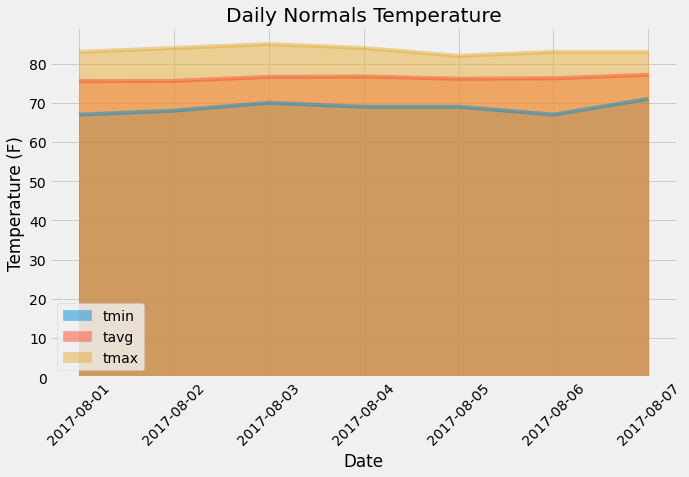

In [16]:
# Plot the daily normals as an area plot with `stacked=False`

normals_df.plot.area(stacked=False, figsize=(10,6))
plt.xticks(rotation=45)
plt.title(f"Daily Normals Temperature")
plt.ylabel("Temperature (F)")
plt.savefig("Images/dailynormals.png")
plt.show


## Close Session

In [17]:
# Close Session
session.close()